In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

In [2]:
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['font.size'] = 18

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
%aimport ospanov

In [5]:
params = {}

params['amin'] = 75
params['amax'] = 90
params['bmin'] = 500
params['bmax'] = 600
params['p1'] = 0.1
params['p2'] = 0.01
params['p3'] = 0.3
params['N'] = 50

### Уточнение прогноза

In [13]:
def count_time(func, args):
    _start = time.time()
    res = func(*args)
    return res, time.time() - _start

In [22]:
def compute(model):
    (pc, _), pc_time = count_time(ospanov.pc, (params, model))
    (pc_a, _), pc_a_time = count_time(ospanov.pc_a, (83, params, model))
    (pc_b, _), pc_b_time = count_time(ospanov.pc_b, (550, params, model))
    (pc_d, _), pc_d_time = count_time(ospanov.pc_d, (18, params, model))
    (pc_ab, _), pc_ab_time = count_time(ospanov.pc_ab, (83, 550, params, model))
    (pc_abd, _), pc_abd_time = count_time(ospanov.pc_abd, (83, 550, 18, params, model))
    (pd, _), pd_time = count_time(ospanov.pd, (params, model))
    return (
        [pc, pc_a, pc_b, pc_d, pc_ab, pc_abd, pd],
        [pc_time, pc_a_time, pc_b_time, pc_d_time, pc_ab_time, pc_abd_time, pd_time]
    )

In [58]:
columns = ['p(c)', 'p(c|a)', 'p(c|b)', 'p(c|d)', 'p(c|a,b)', 'p(c|a,b,d)', 'p(d)']
rows = ['Модель 1', 'Модель 2']

In [59]:
res = [compute(1), compute(2)]

##### Временные замеры

In [60]:
pd.DataFrame([res[0][1], res[1][1]], columns=columns, index=rows)

,p(c),p(c|a),p(c|b),p(c|d),"p(c|a,b)","p(c|a,b,d)",p(d)
Модель 1,0.012417,0.011621,0.000789,0.011432,0.000493,0.000585,0.072148
Модель 2,0.005038,0.004840,0.000393,0.005094,0.000146,0.000253,0.068229


##### Графики

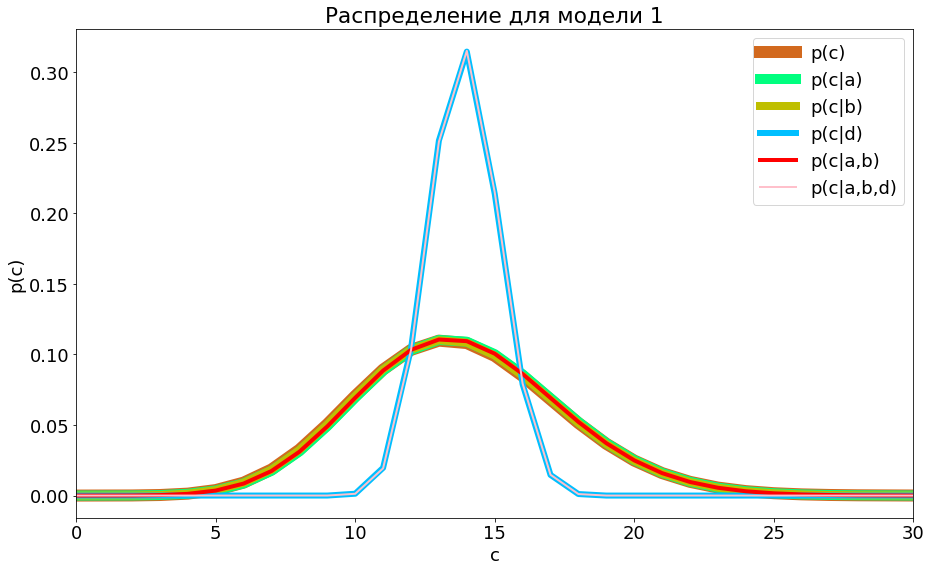

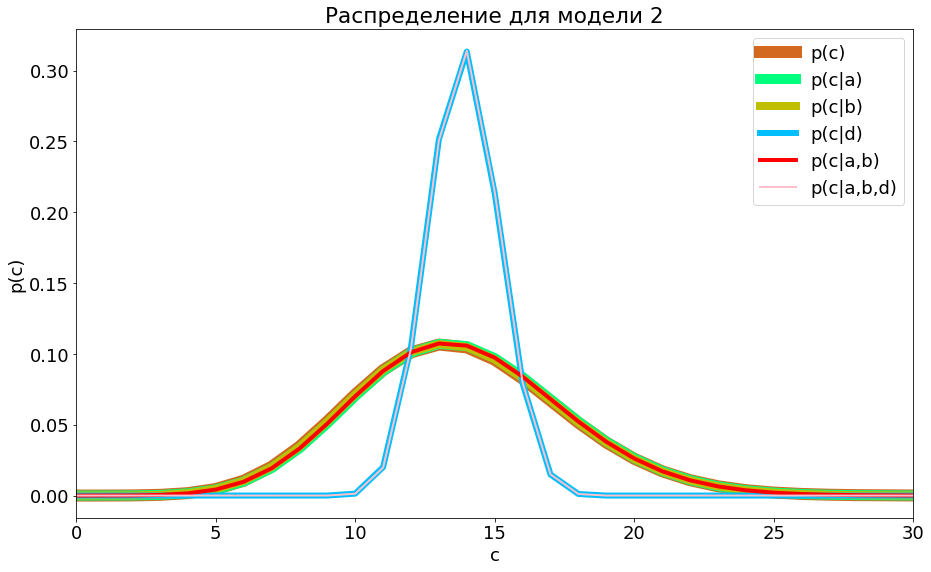

In [105]:
colors = ['chocolate', 'springgreen', 'y', 'deepskyblue', 'r', 'pink']
for model in [0, 1]:
    for i, p in enumerate(res[model][0][:-1]):
        plt.plot(p, label=columns[i], lw=2 * (6 - i), color=colors[i])
    plt.xlim((0, 30))
    plt.legend(loc='best')
    plt.title('Распределение для модели {}'.format(model + 1))
    plt.xlabel('c')
    plt.ylabel('p(c)')
    plt.show()

##### Матожидания и дисперсии

In [106]:
c_carrier = np.arange(params['amax'] + params['bmax'] + 1)

In [111]:
E = [[ospanov.expectation(p, c_carrier) for p in res[model][0][:-1]] for model in [0, 1]]
D = [[ospanov.variance(p, c_carrier) for p in res[model][0][:-1]] for model in [0, 1]]

In [115]:
pd.DataFrame(data=[E[0], D[0]], index=['E', 'D'], columns=columns[:-1])

,p(c),p(c|a),p(c|b),p(c|d),"p(c|a,b)","p(c|a,b,d)"
E,13.7500,13.8,13.7500,13.895971,13.800,13.902756
D,13.1675,13.0,13.0825,1.533582,12.915,1.530140


In [116]:
pd.DataFrame(data=[E[1], D[1]], index=['E', 'D'], columns=columns[:-1])

,p(c),p(c|a),p(c|b),p(c|d),"p(c|a,b)","p(c|a,b,d)"
E,13.7500,13.800,13.7500,13.893834,13.8,13.900175
D,14.0475,13.885,13.9625,1.543943,13.8,1.540884


### Наибольший вклад в уточнение прогноза

In [120]:
a_carrier = np.arange(params['amin'], params['amax'] + 1)
b_carrier = np.arange(params['bmin'], params['bmax'] + 1)
d_carrier = np.arange(2 * (params['amax'] + params['bmax']) + 1)

In [132]:
Dc_a = [[ospanov.variance(*ospanov.pc_a(a, params, model)) for a in a_carrier] for model in [1, 2]]
Dc_b = [[ospanov.variance(*ospanov.pc_b(b, params, model)) for b in b_carrier] for model in [1, 2]]
Dc_d = [[ospanov.variance(*ospanov.pc_d(d, params, model)) for d in d_carrier] for model in [1, 2]]

/home/ospanoff/Development/MMP_magistracy/BMML/task1/ospanov.py:96: RuntimeWarning: invalid value encountered in true_divide
  if pC_D.sum() < 0.00001:


In [135]:
for i in [0, 1]:
    print(np.nanmax(Dc_d[i]), np.nanmin(Dc_a[i]), np.nanmin(Dc_b[i]))

10.2986909051 12.28 12.5875
12.8941557054 13.085 13.4625


### Сравнение моделей

In [157]:
c_carrier = np.arange(params['amax'] + params['bmax'] + 1)
params_tmp = params
params_tmp['p1'] = 0.99
params_tmp['p2'] = 0.99

Dc_a = [[ospanov.variance(*ospanov.pc_ab(100, 200, params_tmp, model))] for model in [1, 2]]

In [158]:
Dc_a

[[2.0746983826247742], [296.99999999816646]]